In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVBeam
import healpy as hp
from scipy.signal import deconvolve
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import wiener

# Add Noise to the Beam

In [2]:
def hera_beam_freq_slice(hera_beam, freq, beam_center = 90, ang_from_center = 15, n = 100):
    '''
    Returns a beam cut at a defined frequency
    
    Parameters
    ----------
    hera_beam : UVBeam
        HERA beam model simulation read into a UVBeam object
    freq: int
        Frequency to pull from simulation
    beam_center: float, optional
        Zenith declination, set to 90 degrees in the simulation
    ang_from_center: int
        Angle from zenith to map the simulated beam out to
    n: int
        Number of points in the plot 
    
    Returns
    -------
    ang : array-like
        Angle from zenith for each point in the beam model
    beam_slice: array-like
        Beam model at the given frequency and angle range
    
    '''
    ang = np.linspace(beam_center-ang_from_center,beam_center+ang_from_center,n)
    beam_slice     = []
    beam_map       = hera_beam[:,freq-50]
    beam_map_norm  = beam_map/np.max(beam_map) 

    for i in ang:
        beam_slice.append(hp.get_interp_val(beam_map_norm, 0, i, lonlat=True))  
    
    return ang, np.array(beam_slice)

In [241]:
hera_beam_file = '/Users/tyler/Desktop/Desktop/Research/HERA/Tsys/data/HERA_beam_nic.hmap'
hera_im = fits.getdata(hera_beam_file, extname='BEAM_{0}'.format('X'))
nside = hp.npix2nside(hera_im.shape[0])
temp_f = fits.getdata(hera_beam_file, extname='FREQS_{0}'.format('X'))

In [242]:
hera_im.shape

(49152, 201)

In [243]:
ang, beam = hera_beam_freq_slice(hera_im, 100, ang_from_center=90, n=300)

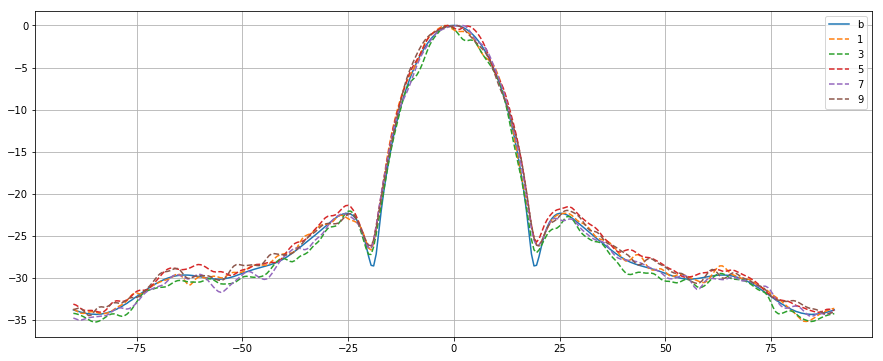

In [10]:
plt.figure(figsize=(15,6))

plt.plot(ang-90, 10*np.log10(beam/beam.max()), label='b')
for i in np.arange(1,10,2):
    w_noise = gaussian_filter(beam+beam*np.random.normal(scale=0.25,size=300), sigma=2.0)
    plt.plot(ang-90, 10*np.log10(w_noise/w_noise.max()), '--', label='{}'.format(i))
    
plt.legend()
plt.grid()
plt.show()

## Narrowing the Beam

In [16]:
def beam_cut(hera_beam, beam_center = 90, ang_from_center = 15, n = 100):
    ang = np.linspace(beam_center-ang_from_center,beam_center+ang_from_center,n)
    beam_slice     = [] 
    
    for i in ang:
        beam_slice.append(hp.get_interp_val(hera_beam, 0, i, lonlat=True))
    return np.array(ang)-90, np.array(beam_slice)

In [17]:
theta_arr = np.zeros(int(hera_im[:,50].shape[0]))
phi_arr = np.zeros(int(hera_im[:,50].shape[0]))

for i in np.arange(int(hera_im[:,50].shape[0])):
    theta, phi = hp.pix2ang(nside, i)
    theta_arr[i] = theta
    phi_arr[i] = phi

In [183]:
hp.pix2ang(nside, np.arange(int(hera_im[:,50].shape[0])))

(array([0.01275785, 0.01275785, 0.01275785, ..., 3.12883481, 3.12883481,
        3.12883481]),
 array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
        5.49778714]))

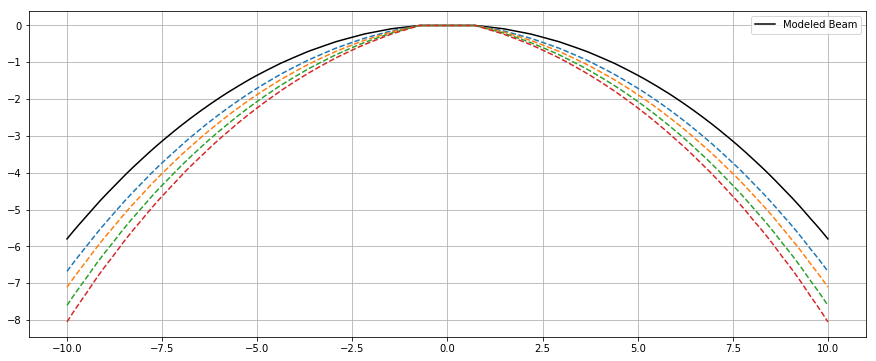

In [181]:
freq = 100

ang, beam = beam_cut(hera_im[:,freq-50], ang_from_center=10, n=400)

plt.figure(figsize=(15,6))
plt.plot(ang,10*np.log10(beam), 'k', label='Modeled Beam')
#plt.plot(ang,beam, 'k', label='Modeled Beam')
fwhm = []
fwhm.append(np.abs(ang[np.argmin(np.abs(beam - beam.max()/2.0))]))


h_max, _ = hp.pix2ang(nside, np.argmin(np.abs(hera_im[:,freq-50] - hera_im[:,freq-50].max() / 2.0)))

perc = np.array([0.1,0.15,0.2,0.25])

for j in perc:
    
    shift = h_max*(1+j) - h_max
    scale = hp.get_interp_val(hera_im[:,freq-50], theta_arr + shift,  phi_arr + shift)    
    scale *= hera_im[:,freq-50].max() / scale.max()
    ang, beam_scale = beam_cut(scale, ang_from_center=10, n=400)
    fwhm.append(np.abs(ang[np.argmin(np.abs(beam_scale - beam_scale.max()/2.0))]))
    #plt.plot(ang, beam_scale, linestyle='--')
    plt.plot(ang, 10*np.log10(beam_scale), linestyle='--')
    
fwhm = np.array(fwhm)
    
plt.legend()
plt.grid()
plt.show()


In [182]:
np.abs(fwhm-fwhm[0])/fwhm

array([0.        , 0.08921933, 0.14007782, 0.19591837, 0.24680851])

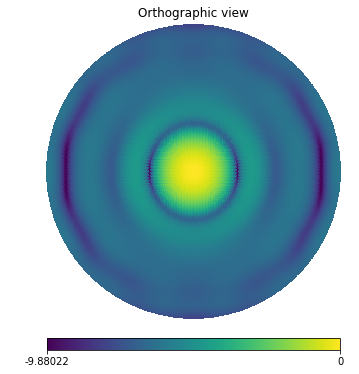

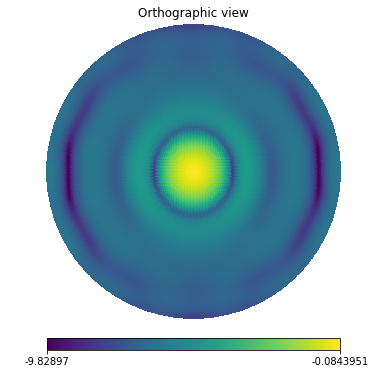

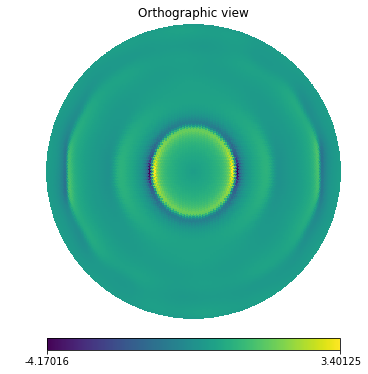

In [119]:
scale = hp.get_interp_val(hera_im[:,50], theta_arr+s,  phi_arr+s/2.0)

hp.orthview(np.log(hera_im[:,50]), rot=[0,90], half_sky=True)
hp.orthview(np.log(scale), rot=[0,90], half_sky=True)
hp.orthview(np.log(hera_im[:,50])-np.log(scale), rot=[0,90], half_sky=True)

# Widening the Beam

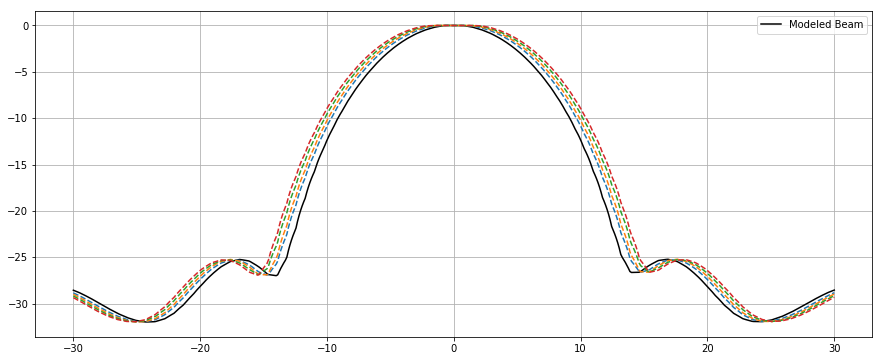

In [159]:
freq = 150


ang, beam = beam_cut(hera_im[:,freq-50], ang_from_center=30, n=500)

plt.figure(figsize=(15,6))
plt.plot(ang,10*np.log10(beam), 'k', label='Modeled Beam')
#plt.plot(ang,beam, 'k', label='Modeled Beam')

h_max, _ = hp.pix2ang(nside, np.argmin(np.abs(hera_im[:,freq-50] - hera_im[:,freq-50].max() / 2.0)))

perc = [0.1,0.15,0.2,0.25]

for j in perc:
    
    s = h_max*(1+j)-h_max
    
    t = theta_arr-s
    p = phi_arr-s
    
    t[t < 0] = 0
    p[p < 0] = 0
    
    scale = hp.get_interp_val(hera_im[:,freq-50], t, p)
    ang, beam_scale = beam_cut(scale, ang_from_center=30, n=500)

    plt.plot(ang, 10*np.log10(beam_scale), linestyle='--')
    #plt.plot(ang, beam_scale, linestyle='--')
    
plt.legend()
plt.grid()
plt.show()

# Scaling the Sidelobes

In [28]:
ang, beam_scale = beam_cut(hera_im[:,100], ang_from_center=90, n=400)
ang, beam = beam_cut(hera_im[:,100], ang_from_center=90, n=400)

beam_scale[beam_scale < 0.01] *= 0.1

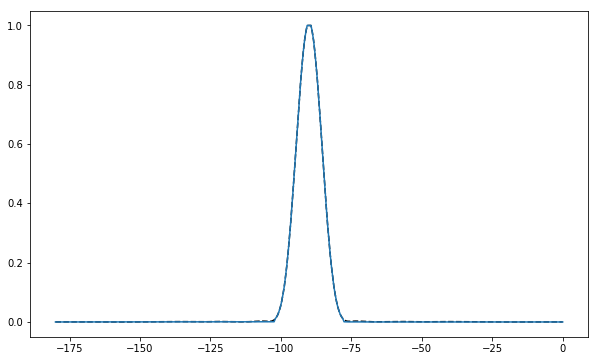

In [29]:
plt.figure(figsize=(10,6))
plt.plot(ang-90,beam, 'k--')
plt.plot(ang-90,beam_scale)
plt.show()

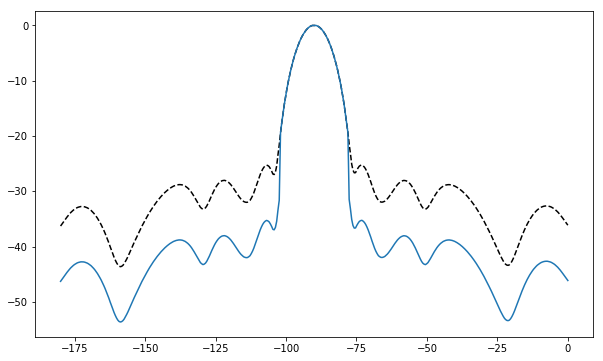

In [30]:
plt.figure(figsize=(10,6))
plt.plot(ang-90,10*np.log10(beam), 'k--')
plt.plot(ang-90,10*np.log10(beam_scale/beam.max()))
plt.show()

(0, 0.005)

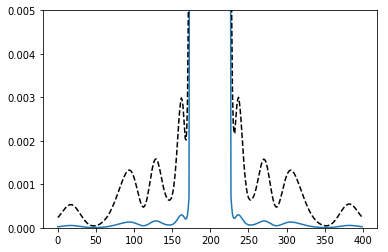

In [31]:
plt.plot(beam_scale)
plt.plot(beam, 'k--')
plt.ylim([0,0.005])

# Narrow and Add Noise

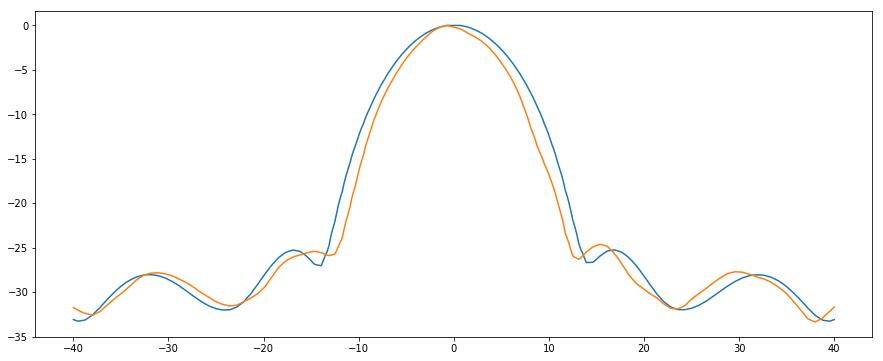

In [247]:
beam = np.copy(hera_im[:, 100])


# Add Noise

sigma = 0.4

deg = 1
deg_to_rad = np.pi / 180.0
sig_to_fwhm = 2.4

np.random.seed(1)

noise = beam * np.random.normal(scale=sigma, size=beam.shape[0])
beam += hp.sphtfunc.smoothing(noise,fwhm=deg_to_rad*sig_to_fwhm*deg, verbose=False)


# Narrow Beam

narrow_frac = 0.25

theta_arr, phi_arr = hp.pix2ang(nside, np.arange(beam.shape[0]))
h_max, _ = hp.pix2ang(nside, np.argmin(np.abs(hera_im[:, 100] -
                                       hera_im[:, 100].max() / 2.0)))
shift = h_max*(1+narrow_frac)-h_max
beam = hp.get_interp_val(beam, theta_arr+shift,  phi_arr+shift/2.0)
beam *= hera_im[:, 100].max() / beam.max()


# Plot

plt.figure(figsize=(15,6))
ang, noise_slice = beam_cut(beam, ang_from_center = 40, n=400)
ang, beam_slice = beam_cut(hera_im[:, 100], ang_from_center=40, n=400)

plt.plot(ang, 10*np.log10(np.abs(beam_slice)/beam_slice.max()))
plt.plot(ang, 10*np.log10(np.abs(noise_slice)/noise_slice.max()))